## Project Description

This project focuses on traffic sign recognition a  core component of many Advanced Driver Assistance Systems (ADAS) that help improve road safety. Using the German Traffic Sign Recognition Benchmark (GTSRB) dataset, which contains 43 types of real-world signs such as speed limits, warnings, and directions, I developed a multi-class image classification model. 

The model is based on a pretrained **EfficientNetB0** architecture, fine-tuned for this specific task. Data augmentation was applied to make the system more robust to variations in lighting, angle, and scale. 

Throughout training, **Weights & Biases (wandb)** was used to track experiments, visualize learning progress, and maintain a record of model versions.


# **Visualizing Sample Images from Each Class in the GTSRB Training Dataset**

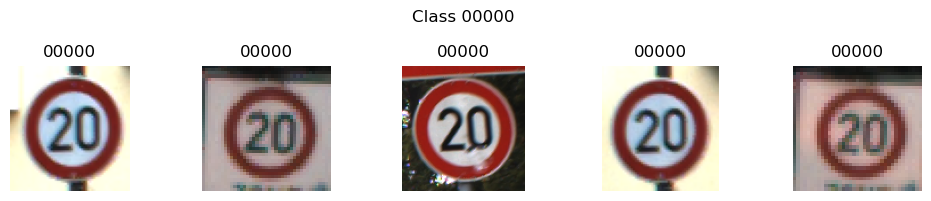

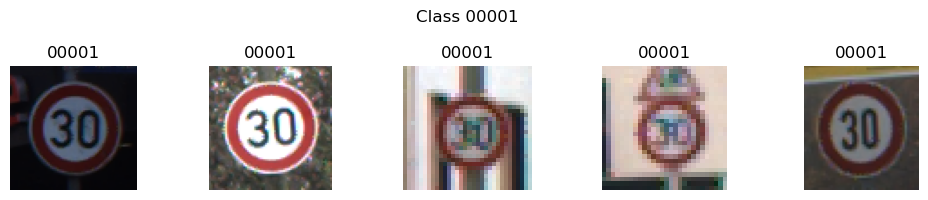

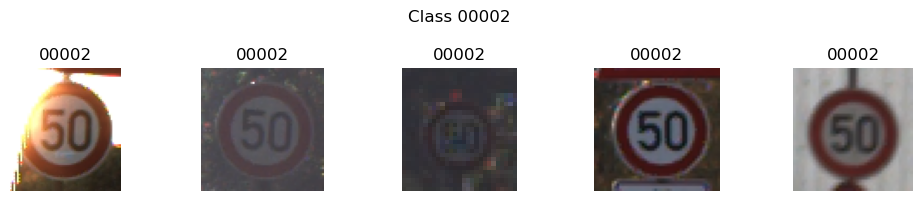

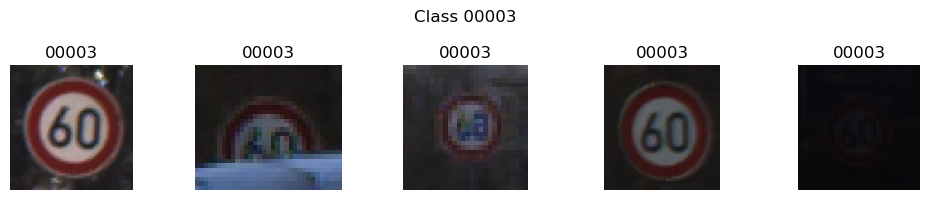

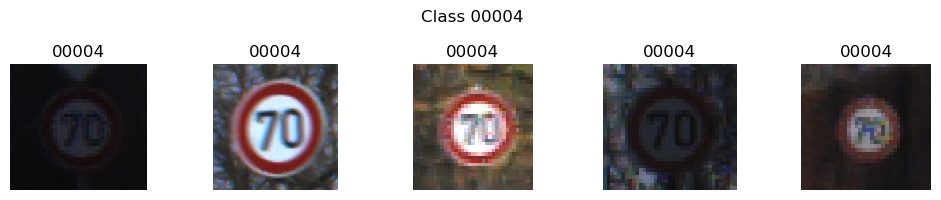

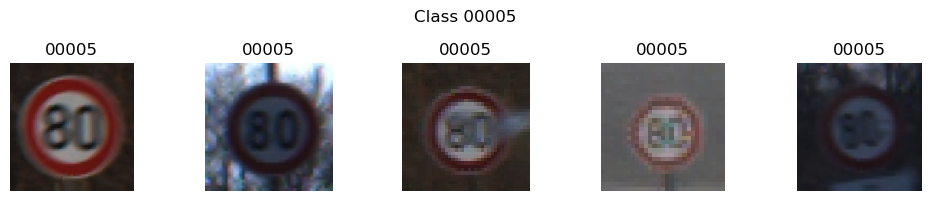

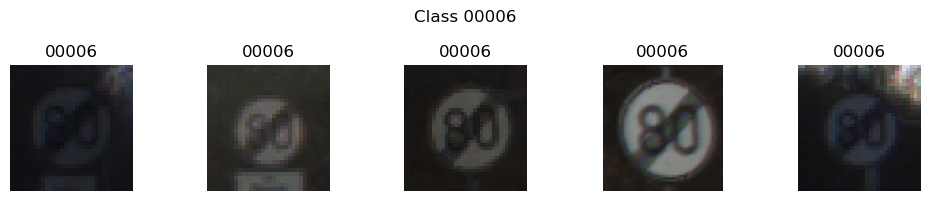

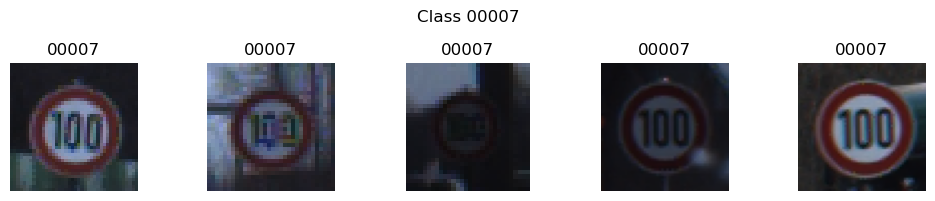

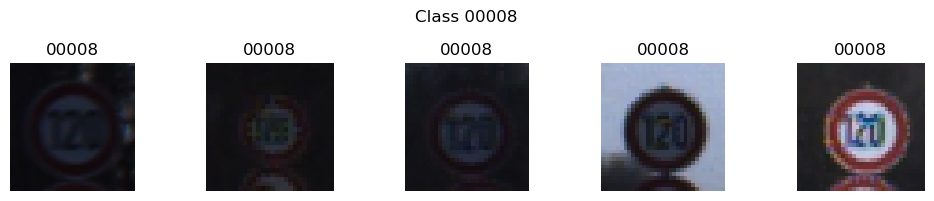

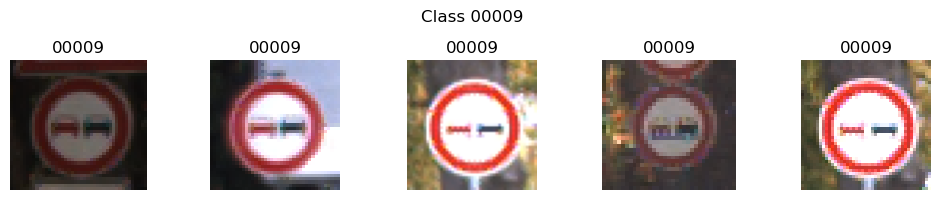

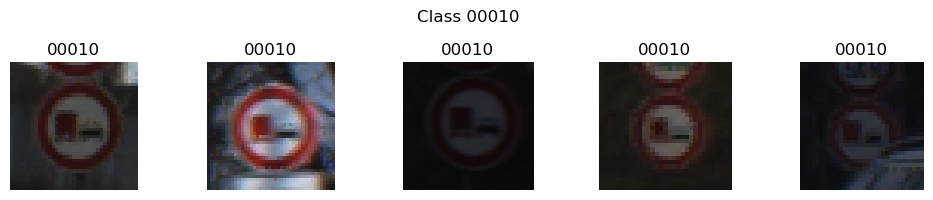

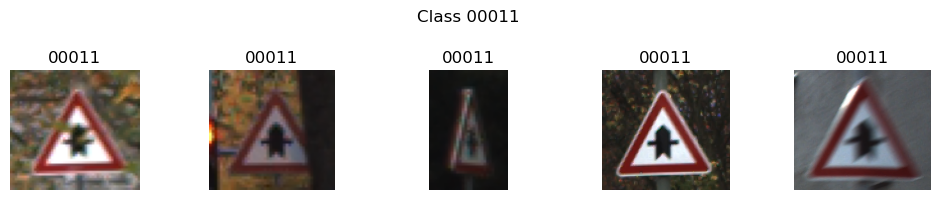

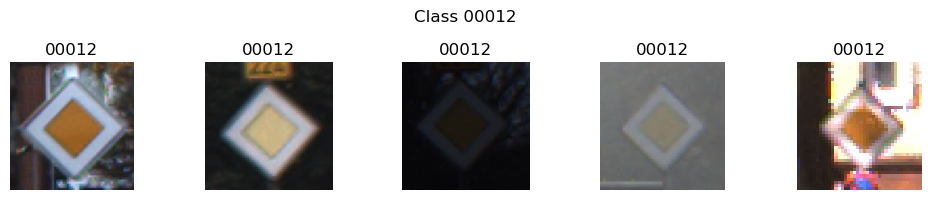

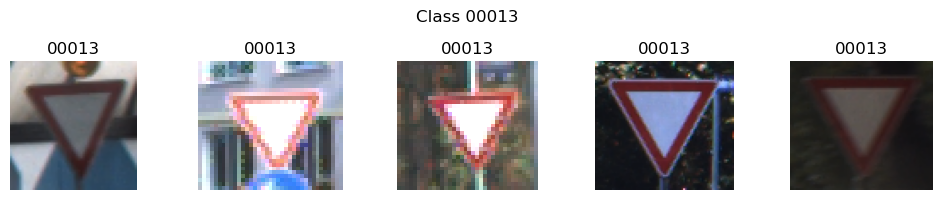

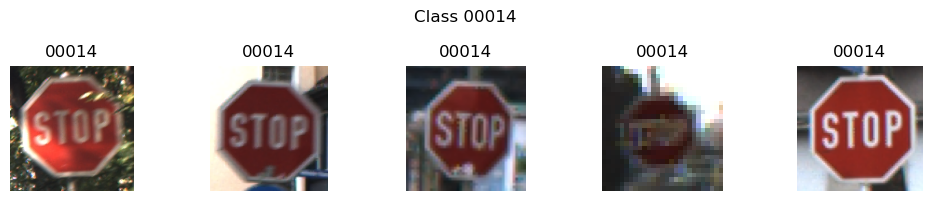

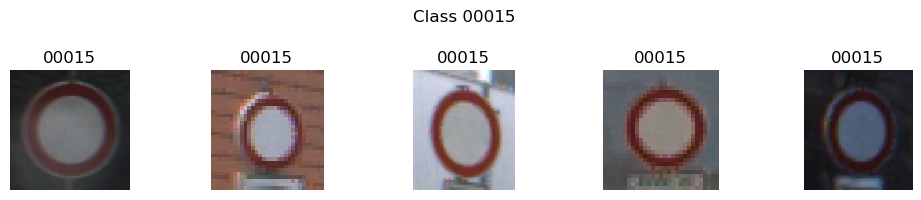

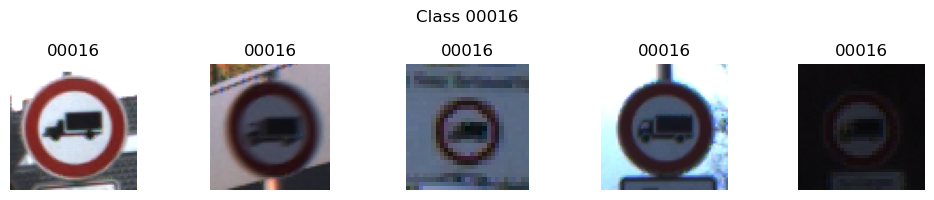

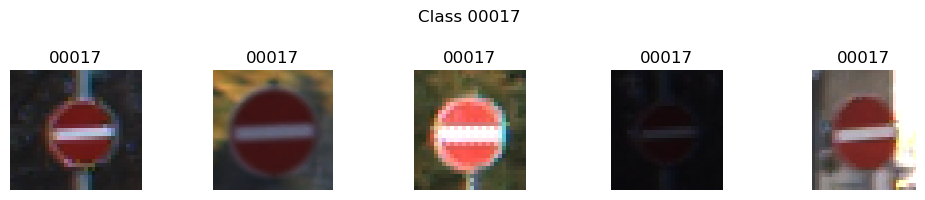

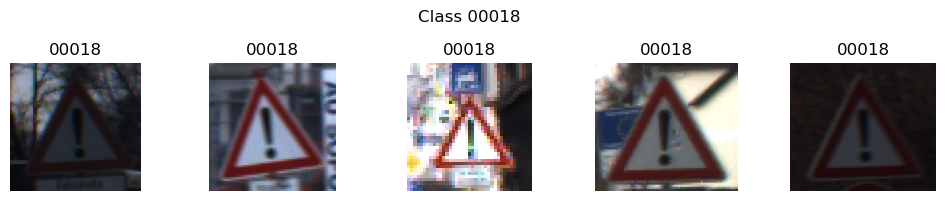

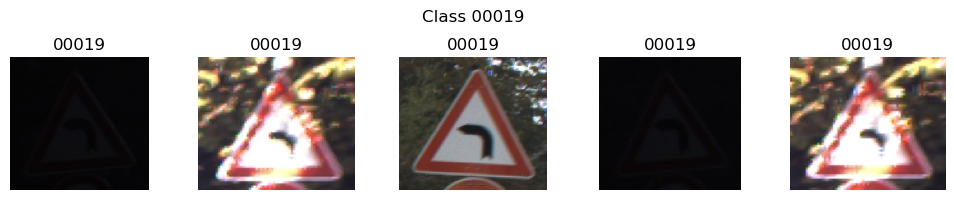

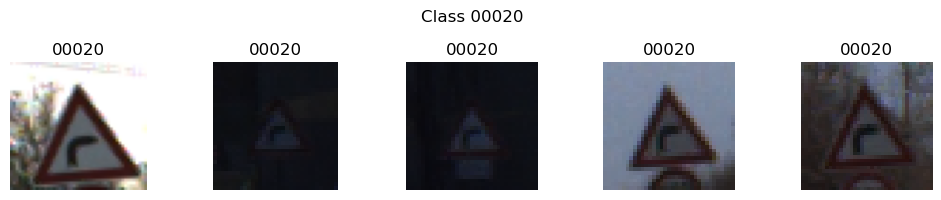

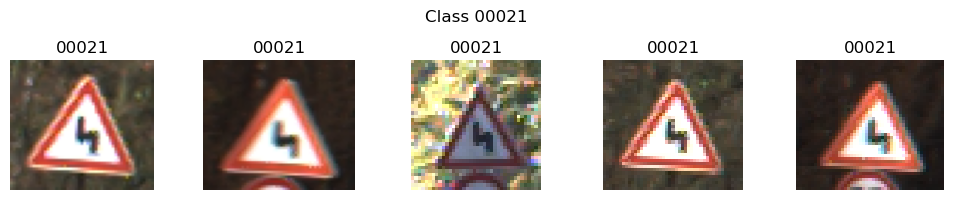

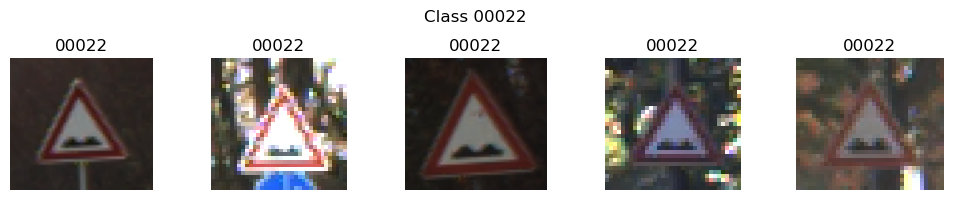

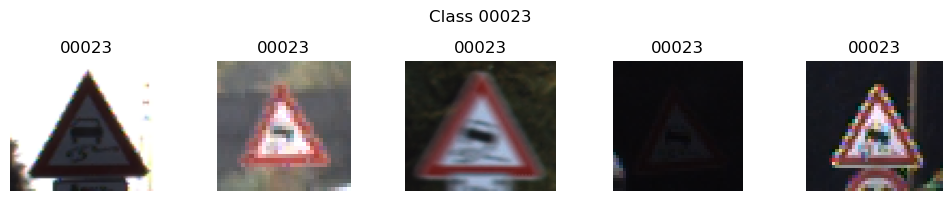

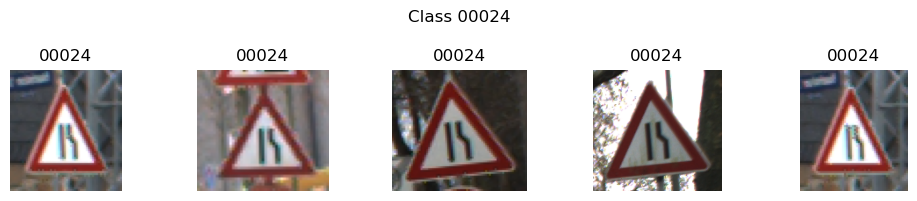

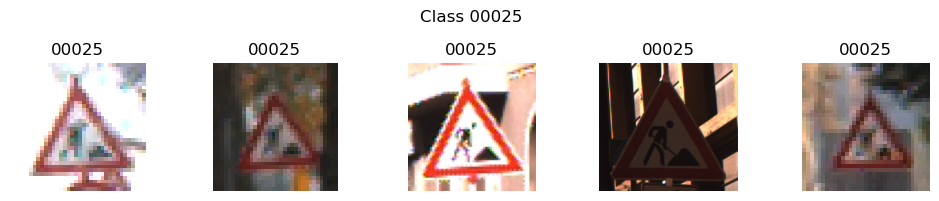

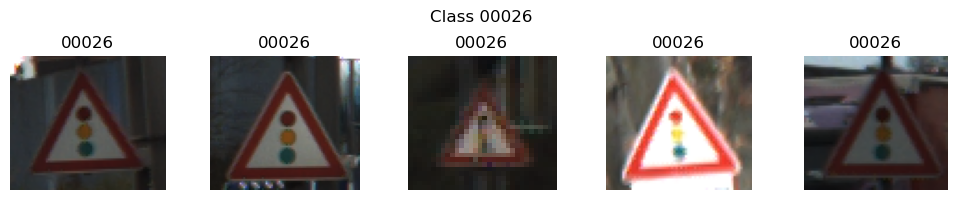

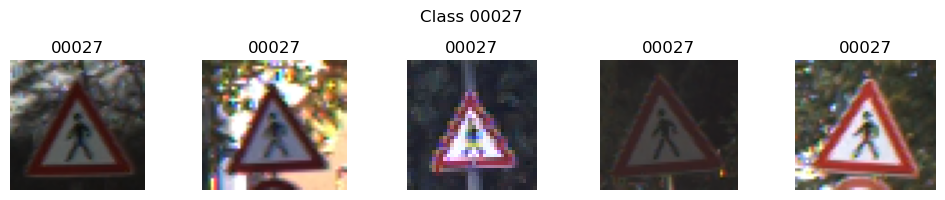

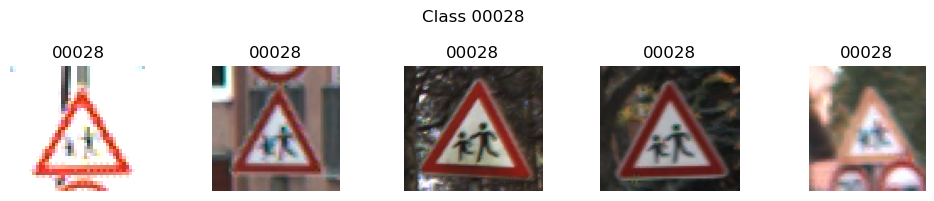

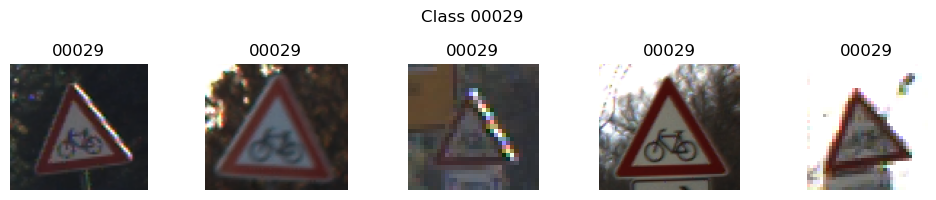

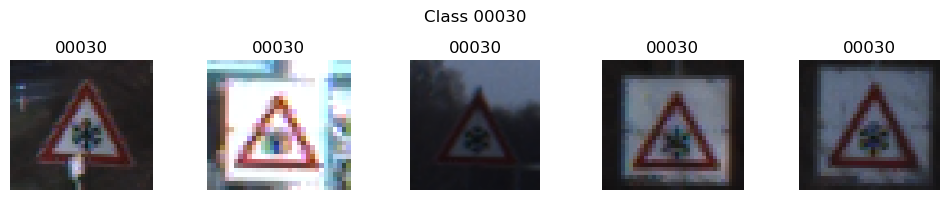

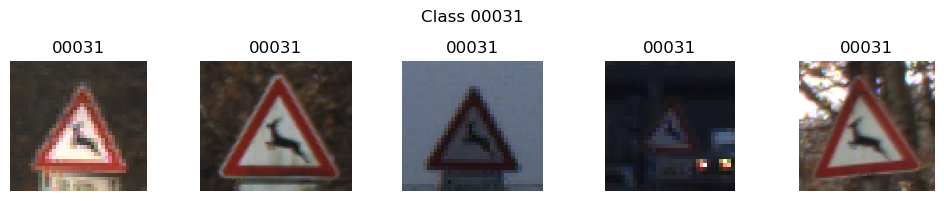

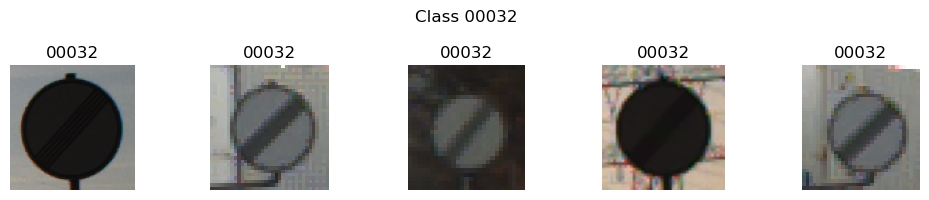

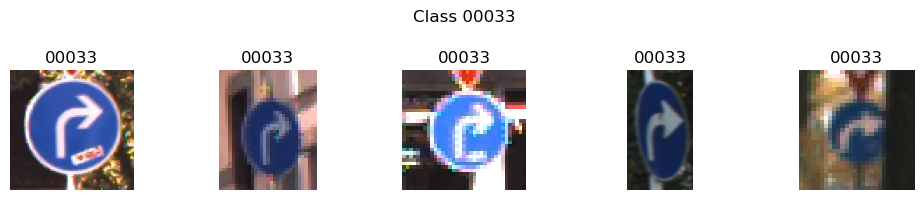

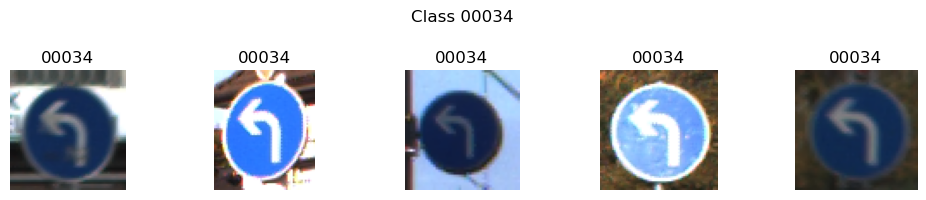

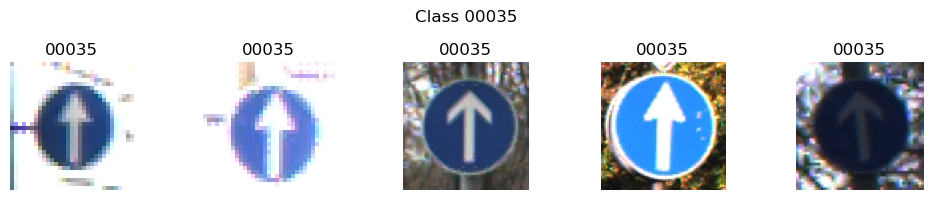

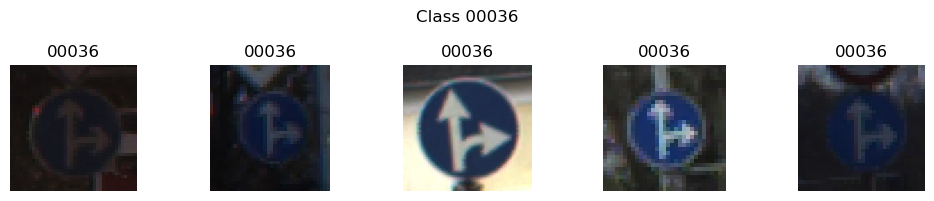

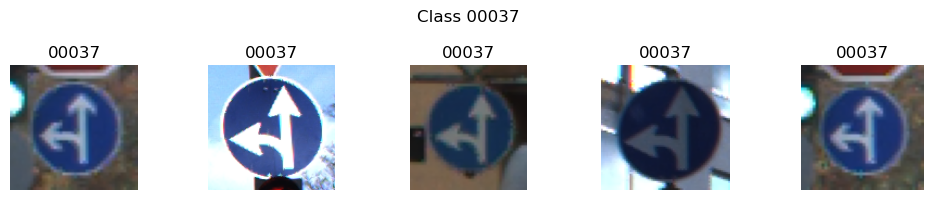

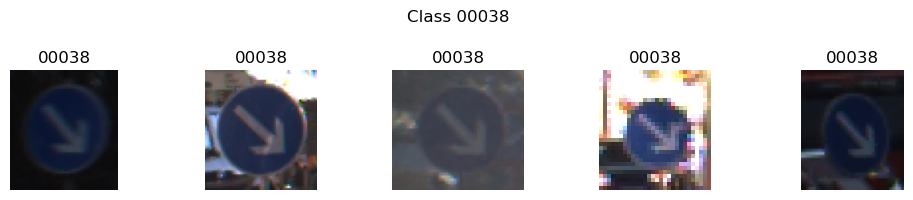

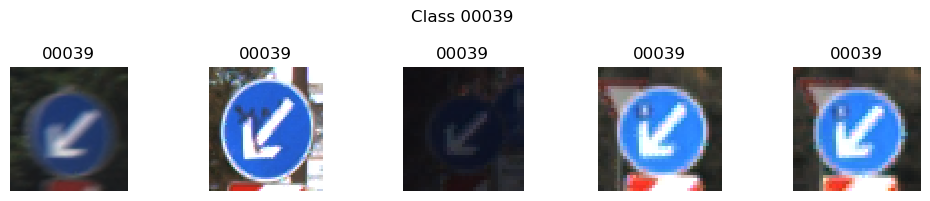

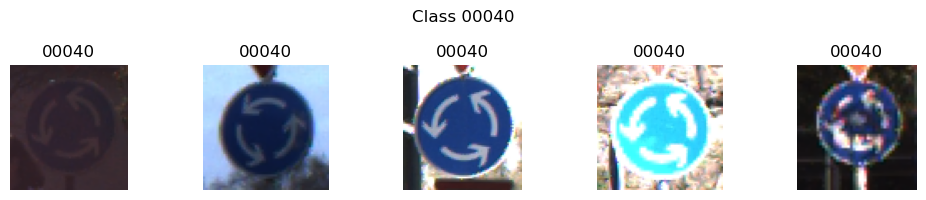

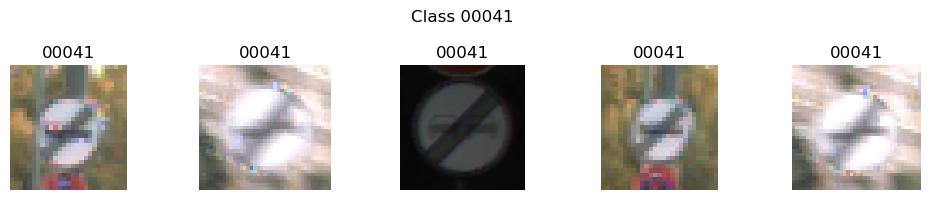

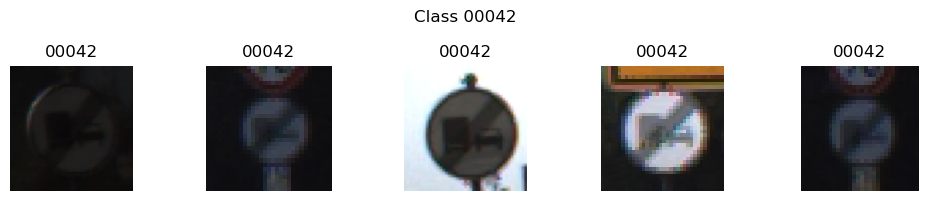

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set your dataset path
root_dir = "/home/srka007f/0_lk_TrafficSignal/GTSRB/data/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images"

# Get list of class directories (00000 - 00042)
class_dirs = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

# Loop through each class
for class_id in class_dirs:
    class_path = os.path.join(root_dir, class_id)
    image_files = [f for f in os.listdir(class_path) if f.endswith(".ppm")]
    
    # Show 5 images
    plt.figure(figsize=(10, 2))
    for i in range(5):
        img_path = os.path.join(class_path, image_files[i])
        img = Image.open(img_path)
        
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{class_id}")
    
    plt.suptitle(f"Class {class_id}")
    plt.tight_layout()
    plt.show()


# **Splitting GTSRB Dataset into Train and Validation Sets Using Symlinks**

This script takes the original GTSRB training dataset, shuffles each class’s images,
and splits them into training and validation subsets based on a defined ratio (default 80/20).
Instead of duplicating files, it creates symbolic links to save storage space.


In [ ]:
import os
import random
from pathlib import Path

def split_with_symlinks(src_dir, dest_root, split_ratio=0.8, seed=42):
    random.seed(seed)

    src_dir = Path(src_dir)
    dest_root = Path(dest_root)

    if not src_dir.exists():
        raise FileNotFoundError(f"Source directory not found: {src_dir}")

    train_dir = dest_root / "train"
    val_dir = dest_root / "val"

    # Clean up existing split folders if they exist
    for dir_path in [train_dir, val_dir]:
        if dir_path.exists():
            print(f"Removing existing directory: {dir_path}")
            os.system(f"rm -rf {dir_path}")

    class_dirs = [d for d in src_dir.iterdir() if d.is_dir()]

    for class_dir in class_dirs:
        class_name = class_dir.name
        images = list(class_dir.glob("*"))
        if not images:
            continue

        random.shuffle(images)
        split_idx = int(len(images) * split_ratio)
        train_imgs = images[:split_idx]
        val_imgs = images[split_idx:]

        for split_name, img_list in zip(["train", "val"], [train_imgs, val_imgs]):
            dest_class_dir = dest_root / split_name / class_name
            dest_class_dir.mkdir(parents=True, exist_ok=True)

            for img_path in img_list:
                symlink_path = dest_class_dir / img_path.name
                try:
                    os.symlink(img_path.resolve(), symlink_path)
                except FileExistsError:
                    continue

    print("Symlinked train/val split completed.")

# === Usage ===

split_with_symlinks(
    src_dir="/home/srka007f/0_lk_TrafficSignal/GTSRB/data/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images",
    dest_root="/home/srka007f/0_lk_TrafficSignal/GTSRB/data/training and validation data",
    split_ratio=0.8
)

# **Training EfficientNetB0 on GTSRB Dataset with W&B Integration**

This cell configures GPU settings, prepares data generators for training and validation,
builds an EfficientNetB0-based classification model, integrates custom metrics logging,
and trains the model using callbacks for checkpointing, early stopping, and learning rate scheduling.


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, EarlyStopping, ModelCheckpoint,
    CSVLogger, Callback
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Input
from sklearn.metrics import precision_score, recall_score, f1_score
from wandb.integration.keras import WandbMetricsLogger
import wandb
import numpy as np
import os
import shutil

# ==== GPU CONFIGURATION ====
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[2], 'GPU')  # USE GPU:2
        tf.config.experimental.set_memory_growth(gpus[2], True)
        print("Using GPU:", gpus[2])
    except RuntimeError as e:
        print("Error setting GPU config:", e)
else:
    print("No GPU detected. Running on CPU.")

# ==== Init Weights & Biases ====
wandb.login(key="9440b98a45c0030eb13652413dd35c1f5e7b1859")
wandb.init(project="efficientnet_gtsrb", name="run_efficientnet_rgb")

# ==== Config ====
IMG_SIZE = (224, 224)
BATCH_SIZE = 16  # Reduced to prevent OOM
NUM_CLASSES = 43
EPOCHS = 50

TRAIN_DIR = "/home/srka007f/0_lk_TrafficSignal/GTSRB/data/training and validation data/train"
VAL_DIR   = "/home/srka007f/0_lk_TrafficSignal/GTSRB/data/training and validation data/val"

BACKUP_DIR = "/home/srka007f/0_lk_TrafficSignal/models/efficienet b0_ version_1"
os.makedirs(BACKUP_DIR, exist_ok=True)

MODEL_PATH = os.path.join(BACKUP_DIR, "best_model.keras")
LOG_FILE   = os.path.join(BACKUP_DIR, "training_log.csv")

# ==== Data Generators ====
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# ==== Custom Metrics Callback ====
class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_preds = self.model.predict(val_generator, verbose=0)
        val_preds_labels = np.argmax(val_preds, axis=1)
        val_true_labels = val_generator.classes

        precision = precision_score(val_true_labels, val_preds_labels, average='weighted')
        recall = recall_score(val_true_labels, val_preds_labels, average='weighted')
        f1 = f1_score(val_true_labels, val_preds_labels, average='weighted')

        print(f"\n Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

        wandb.log({
            "val_precision": precision,
            "val_recall": recall,
            "val_f1_score": f1,
            "epoch": epoch
        })

# ==== Build Model ====
input_tensor = Input(shape=(224, 224, 3))
with tf.device('/GPU:2'):  # <-- GPU selection
    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=input_tensor)

    # Load pretrained ImageNet weights manually
    weights_path = tf.keras.utils.get_file(
        "efficientnetb0_notop.h5",
        "https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5"
    )
    base_model.load_weights(weights_path)
    base_model.trainable = True

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=outputs)

# ==== Compile ====
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ==== Callbacks ====
callbacks = [
    WandbMetricsLogger(),
    MetricsCallback(),
    ModelCheckpoint(filepath=MODEL_PATH, save_best_only=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    CSVLogger(LOG_FILE)
]

# ==== Train ====
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


✅ Using GPU: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')


Found 31336 images belonging to 43 classes.
Found 7872 images belonging to 43 classes.
Epoch 1/50


I0000 00:00:1754582400.331378 3722929 service.cc:152] XLA service 0x7f0c98003fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754582400.331433 3722929 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-08-07 18:00:01.406070: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754582405.509282 3722929 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-08-07 18:00:11.201143: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-07 18:00:11.370957: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, ple

   1/1959 ━━━━━━━━━━━━━━━━━━━━ 38:32:30 71s/step - accuracy: 0.0000e+00 - loss: 3.9877

I0000 00:00:1754582449.002322 3722929 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 920/1959 ━━━━━━━━━━━━━━━━━━━━ 2:52 166ms/step - accuracy: 0.5640 - loss: 1.5892

2025-08-07 18:03:29.718866: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-07 18:03:29.881139: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-07 18:03:31.528726: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-07 18:03:31.685316: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-07 18:03:32.253371: E external/local_xla/xla/stream_

1959/1959 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7078 - loss: 1.0559

2025-08-07 18:06:59.927757: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2076', 8 bytes spill stores, 8 bytes spill loads

2025-08-07 18:07:01.027657: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2076_0', 200 bytes spill stores, 536 bytes spill loads

2025-08-07 18:07:01.060197: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2076', 124 bytes spill stores, 124 bytes spill loads

2025-08-07 18:07:01.555736: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2076', 6000 bytes spill stores, 5936 bytes spill loads

2025-08-07 18:07:01.838333: I ex


📊 Precision: 0.5661, Recall: 0.1254, F1 Score: 0.1009

Epoch 1: val_loss improved from inf to 5.57054, saving model to /home/srka007f/0_lk_TrafficSignal/models/efficienet b0_ version_1/best_model.keras


/home/srka007f/miniconda3/envs/digit-depth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1959/1959 ━━━━━━━━━━━━━━━━━━━━ 474s 206ms/step - accuracy: 0.7079 - loss: 1.0556 - val_accuracy: 0.1254 - val_loss: 5.5705 - learning_rate: 0.0010
Epoch 2/50
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9713 - loss: 0.1068
📊 Precision: 0.5479, Recall: 0.1954, F1 Score: 0.2571

Epoch 2: val_loss did not improve from 5.57054
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 324s 165ms/step - accuracy: 0.9713 - loss: 0.1068 - val_accuracy: 0.1954 - val_loss: 191.8405 - learning_rate: 0.0010
Epoch 3/50


/home/srka007f/miniconda3/envs/digit-depth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1959/1959 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9797 - loss: 0.0858
📊 Precision: 0.0017, Recall: 0.0373, F1 Score: 0.0033

Epoch 3: val_loss improved from 5.57054 to 4.53095, saving model to /home/srka007f/0_lk_TrafficSignal/models/efficienet b0_ version_1/best_model.keras


/home/srka007f/miniconda3/envs/digit-depth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1959/1959 ━━━━━━━━━━━━━━━━━━━━ 318s 163ms/step - accuracy: 0.9797 - loss: 0.0858 - val_accuracy: 0.0373 - val_loss: 4.5310 - learning_rate: 0.0010
Epoch 4/50
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9829 - loss: 0.0698
📊 Precision: 0.5582, Recall: 0.1828, F1 Score: 0.1793

Epoch 4: val_loss improved from 4.53095 to 3.94830, saving model to /home/srka007f/0_lk_TrafficSignal/models/efficienet b0_ version_1/best_model.keras


/home/srka007f/miniconda3/envs/digit-depth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1959/1959 ━━━━━━━━━━━━━━━━━━━━ 320s 163ms/step - accuracy: 0.9829 - loss: 0.0698 - val_accuracy: 0.1828 - val_loss: 3.9483 - learning_rate: 0.0010
Epoch 5/50
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9827 - loss: 0.0678
📊 Precision: 0.0009, Recall: 0.0305, F1 Score: 0.0018

Epoch 5: val_loss did not improve from 3.94830
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 317s 162ms/step - accuracy: 0.9827 - loss: 0.0678 - val_accuracy: 0.0305 - val_loss: 4.7299 - learning_rate: 0.0010
Epoch 6/50


/home/srka007f/miniconda3/envs/digit-depth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1959/1959 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9894 - loss: 0.0418
📊 Precision: 0.0030, Recall: 0.0549, F1 Score: 0.0057

Epoch 6: val_loss did not improve from 3.94830
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 315s 161ms/step - accuracy: 0.9894 - loss: 0.0418 - val_accuracy: 0.0549 - val_loss: 19.2816 - learning_rate: 0.0010
Epoch 7/50


/home/srka007f/miniconda3/envs/digit-depth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1959/1959 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9870 - loss: 0.0587
📊 Precision: 0.0000, Recall: 0.0062, F1 Score: 0.0001

Epoch 7: val_loss did not improve from 3.94830

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 314s 160ms/step - accuracy: 0.9870 - loss: 0.0587 - val_accuracy: 0.0062 - val_loss: 44.3769 - learning_rate: 0.0010
Epoch 8/50


/home/srka007f/miniconda3/envs/digit-depth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1959/1959 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9962 - loss: 0.0128
📊 Precision: 0.9956, Recall: 0.9956, F1 Score: 0.9955

Epoch 8: val_loss improved from 3.94830 to 0.01554, saving model to /home/srka007f/0_lk_TrafficSignal/models/efficienet b0_ version_1/best_model.keras
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 770s 393ms/step - accuracy: 0.9962 - loss: 0.0128 - val_accuracy: 0.9956 - val_loss: 0.0155 - learning_rate: 2.0000e-04
Epoch 9/50
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9984 - loss: 0.0063
📊 Precision: 0.9079, Recall: 0.8093, F1 Score: 0.8365

Epoch 9: val_loss did not improve from 0.01554
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 324s 165ms/step - accuracy: 0.9984 - loss: 0.0063 - val_accuracy: 0.8093 - val_loss: 0.7853 - learning_rate: 2.0000e-04
Epoch 10/50
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9987 - loss: 0.0055
📊 Precision: 0.8433, Recall: 0.6491, F1 Score: 0.6864

Epoch 10: val_loss did not improve from 0.01554
1959/1959 ━━━━━━━━━━━━━━━━━

# **Evaluating the Trained EfficientNetB0 Model on the GTSRB Test Dataset**

This cell loads the best saved model, preprocesses the GTSRB test images,
runs predictions on the GPU, and generates a classification report and confusion matrix
to assess model performance.


In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix

# ==== GPU CONFIGURATION ====
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[2], 'GPU')  # Use GPU:2 (change if needed)
        tf.config.experimental.set_memory_growth(gpus[2], True)
        print("Using GPU:", gpus[2])
    except RuntimeError as e:
        print(" Error setting GPU config:", e)
else:
    print(" No GPU detected. Running on CPU.")

# ==== PATHS ====
MODEL_PATH = "/home/srka007f/0_lk_TrafficSignal/models/efficienet b0_ version_1/best_model.keras"
CSV_PATH = "/home/srka007f/0_lk_TrafficSignal/GT-final_test.csv"
IMG_DIR = "/home/srka007f/0_lk_TrafficSignal/GTSRB/data/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images"
IMG_SIZE = (224, 224)

# ==== Load Test Data ====
df_test = pd.read_csv(CSV_PATH, sep=';')
df_test = df_test[['Filename', 'ClassId']].rename(columns={'Filename': 'filename', 'ClassId': 'label'})

# ==== Load Model ====
model = load_model(MODEL_PATH)

# ==== Preprocessing Function ====
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0  # Normalize
    return img_array

# ==== Load and Preprocess Test Images ====
X_test = []
y_true = []

print("Loading test images...")
for idx, row in df_test.iterrows():
    img_path = os.path.join(IMG_DIR, row['filename'])
    try:
        img = preprocess_image(img_path)
        X_test.append(img)
        y_true.append(row['label'])
    except Exception as e:
        print(f" Error loading image {row['filename']}: {e}")

X_test = np.array(X_test)
y_true = np.array(y_true)

# ==== Run Predictions on GPU ====
print(f"\n🚀 Predicting {len(X_test)} images on GPU...")
with tf.device('/GPU:2'):  # Use GPU 2 (change if needed)
    y_probs = model.predict(X_test, batch_size=32, verbose=1)
    y_pred = np.argmax(y_probs, axis=1)

# ==== Evaluation Metrics ====
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


2025-08-07 22:21:06.447801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754598066.849266 3816617 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754598066.965884 3816617 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754598067.935247 3816617 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754598067.935284 3816617 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754598067.935287 3816617 computation_placer.cc:177] computation placer alr

✅ Using GPU: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')


I0000 00:00:1754598077.216385 3816617 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38486 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0


🔄 Loading test images...

🚀 Predicting 12630 images on GPU...


I0000 00:00:1754598106.079192 3816972 service.cc:152] XLA service 0x7f828c14c350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754598106.079235 3816972 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-08-07 22:21:46.234243: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754598106.890397 3816972 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-08-07 22:21:49.140527: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2033', 232 bytes spill stores, 232 bytes spill loads

2025-08-07 22:21:49.146287: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2033'

 13/395 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step  

I0000 00:00:1754598121.100994 3816972 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


392/395 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

2025-08-07 22:22:10.920304: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2031_0', 496 bytes spill stores, 1488 bytes spill loads

2025-08-07 22:22:11.002563: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2031', 240 bytes spill stores, 240 bytes spill loads

2025-08-07 22:22:11.031248: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2031', 16 bytes spill stores, 16 bytes spill loads

2025-08-07 22:22:11.485974: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2031', 5924 bytes spill stores, 5992 bytes spill loads

2025-08-07 22:22:11.812513: I

395/395 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step

✅ Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        60
           1     0.9972    1.0000    0.9986       720
           2     0.9987    1.0000    0.9993       750
           3     1.0000    0.9778    0.9888       450
           4     1.0000    0.9985    0.9992       660
           5     0.9859    1.0000    0.9929       630
           6     1.0000    0.9867    0.9933       150
           7     1.0000    0.9978    0.9989       450
           8     0.9978    1.0000    0.9989       450
           9     1.0000    0.9979    0.9990       480
          10     0.9985    1.0000    0.9992       660
          11     0.9976    1.0000    0.9988       420
          12     0.9985    0.9957    0.9971       690
          13     0.9986    0.9986    0.9986       720
          14     1.0000    1.0000    1.0000       270
          15     0.9858    0.9905    0.9881       210
          16

# **Plotting the Normalized Confusion Matrix for GTSRB Predictions**

This cell generates a compact, color-coded confusion matrix for the GTSRB test predictions, 
normalizes the values per class, and overlays the original counts for a detailed performance view.


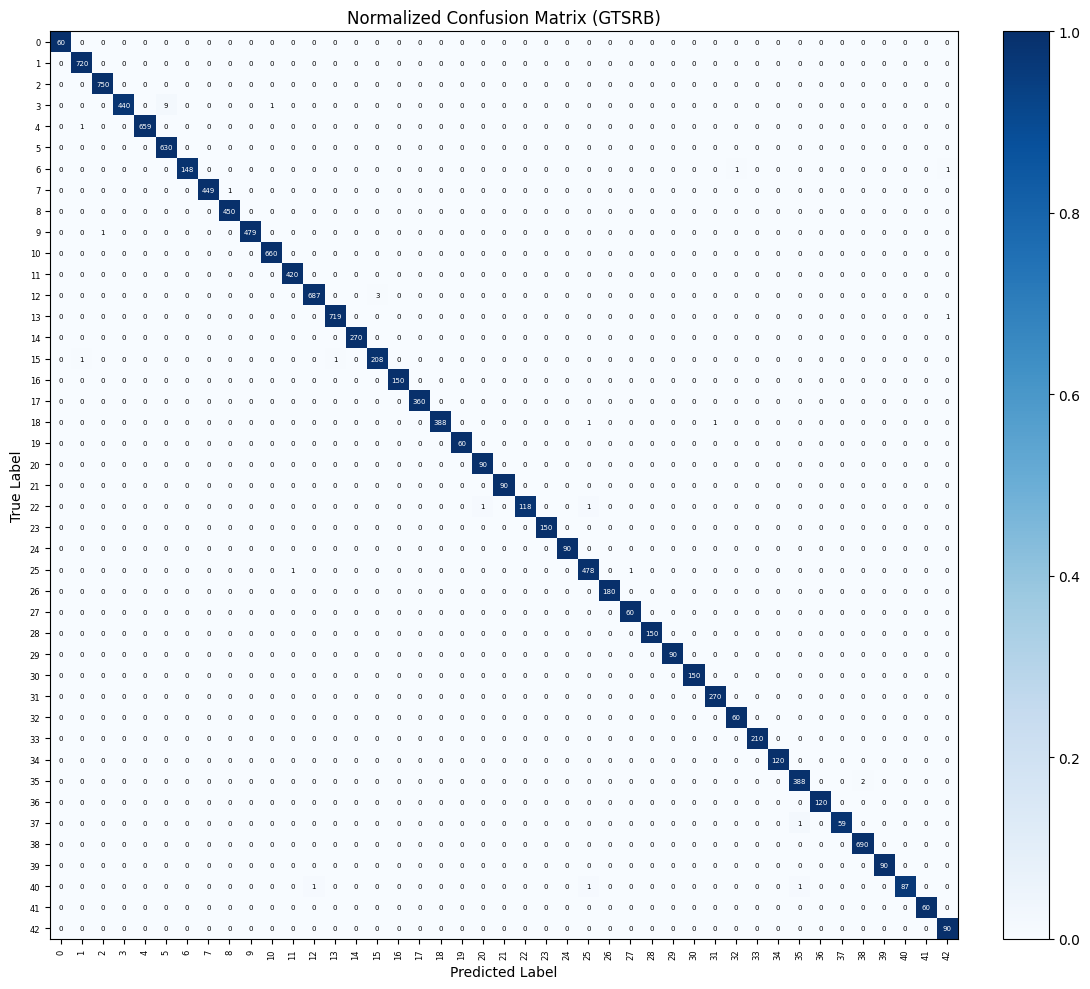

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute and normalize confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create compact plot
fig, ax = plt.subplots(figsize=(12, 10))  # Small but readable
im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
fig.colorbar(im, fraction=0.046, pad=0.04)

# Axis labels and ticks
classes = np.arange(43)
ax.set_xticks(classes)
ax.set_yticks(classes)
ax.set_xticklabels(classes, fontsize=6)
ax.set_yticklabels(classes, fontsize=6)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('True Label', fontsize=10)
plt.title('Normalized Confusion Matrix (GTSRB)', fontsize=12)
plt.xticks(rotation=90)

# Add all cell values (as integers from original matrix)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]),
                ha="center", va="center",
                color="white" if cm_normalized[i, j] > 0.5 else "black",
                fontsize=5)

plt.tight_layout()
plt.show()


# **Visualizing Misclassified Images from GTSRB Test Set**

This cell identifies all misclassified samples from the model’s predictions, 
selects up to 25 examples, and displays them in a grid with their true and predicted labels 
to help analyze model errors.


🔍 Found 33 misclassified images.


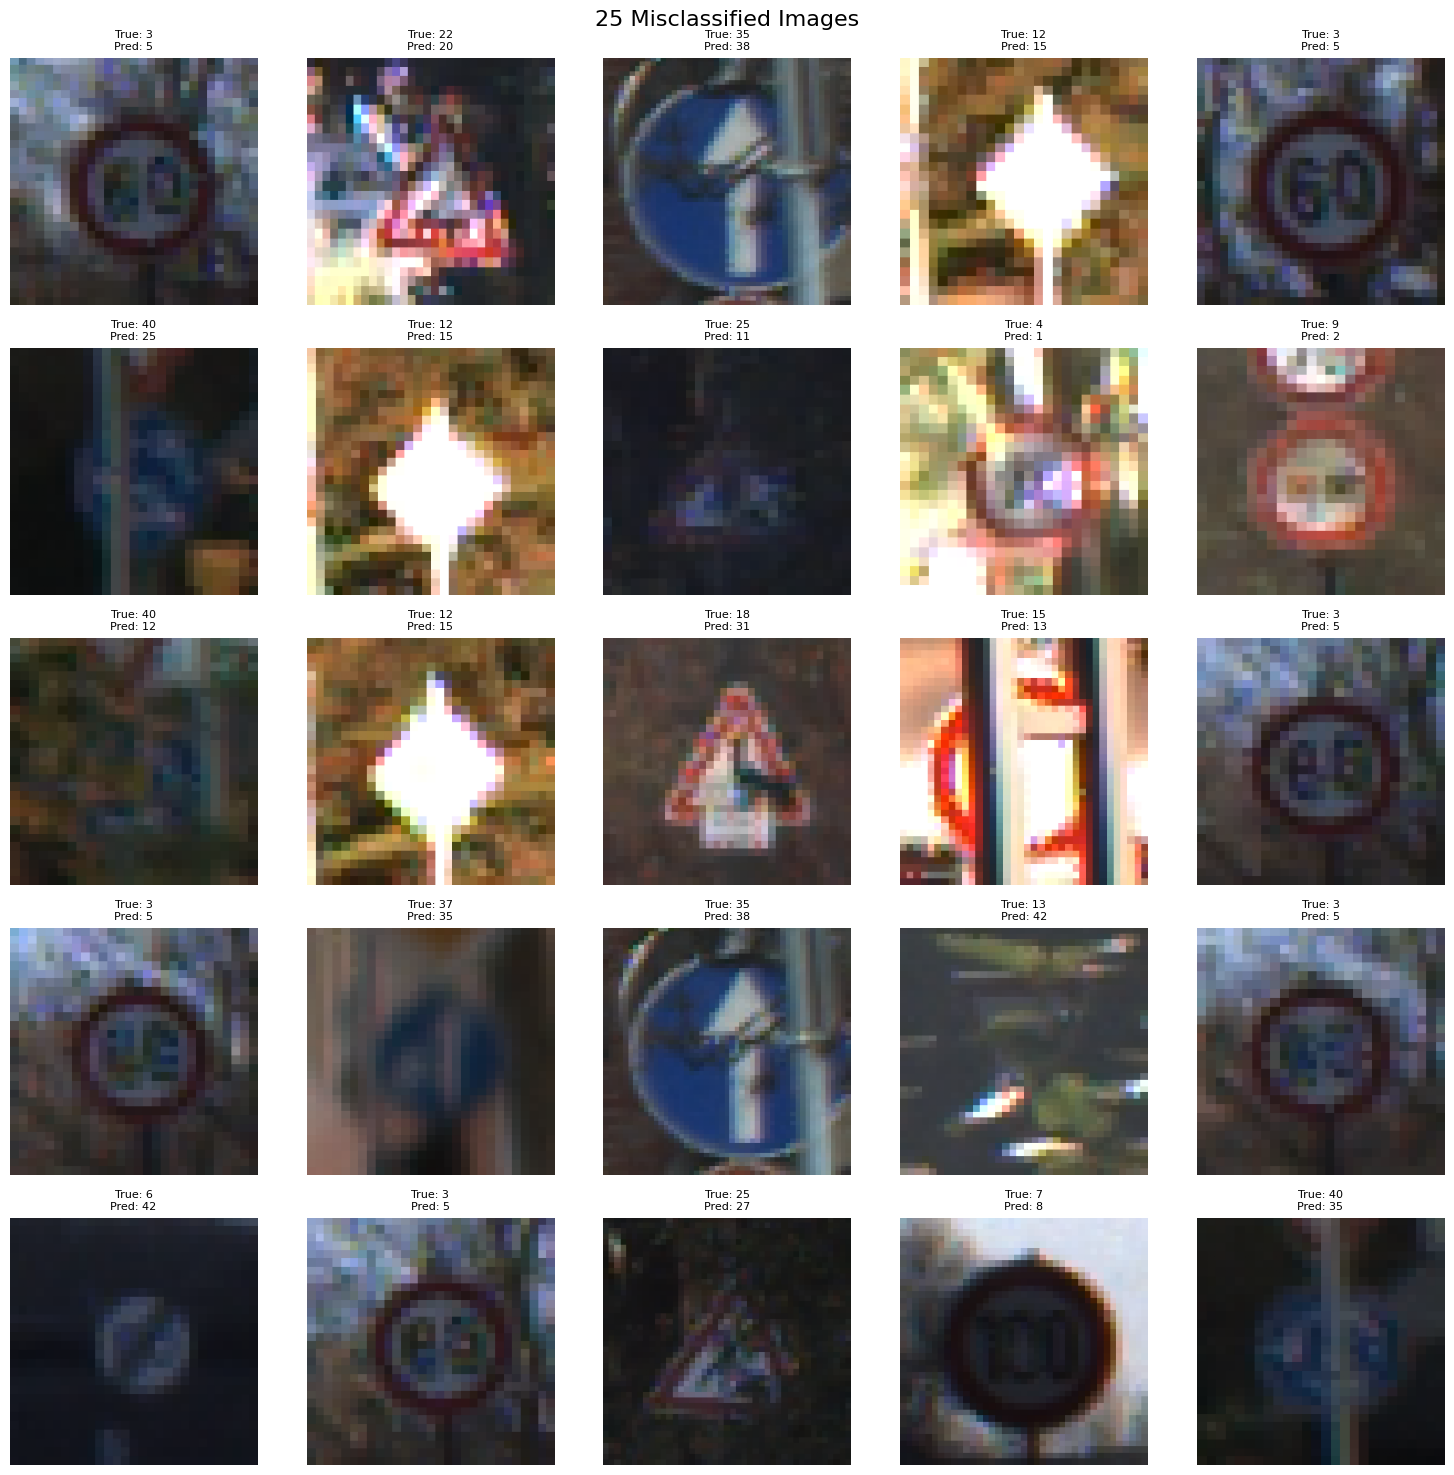

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# ==== CONFIG ====
N = 25  # Number of misclassified images to display (adjust as needed)
IMG_SIZE = (224, 224)
IMG_DIR = "/home/srka007f/0_lk_TrafficSignal/GTSRB/data/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images"

# ==== Find misclassified indices ====
misclassified_idx = np.where(y_pred != y_true)[0]
print(f" Found {len(misclassified_idx)} misclassified images.")

# ==== Show a few ====
num_to_show = min(N, len(misclassified_idx))
plt.figure(figsize=(15, 15))

for i, idx in enumerate(misclassified_idx[:num_to_show]):
    # Get image file and paths
    filename = df_test.iloc[idx]['filename']
    img_path = os.path.join(IMG_DIR, filename)

    # Load image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_arr = image.img_to_array(img) / 255.0

    # Plot
    plt.subplot(5, 5, i + 1)  # 5x5 grid
    plt.imshow(img_arr)
    plt.axis('off')
    plt.title(f"True: {y_true[idx]}\nPred: {y_pred[idx]}", fontsize=8)

plt.suptitle(f"{num_to_show} Misclassified Images", fontsize=16)
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd

log_path = "/home/srka007f/0_lk_TrafficSignal/models/efficienet b0_ version_1/training_log.csv"
history_df = pd.read_csv(log_path)

# Show available columns
print(history_df.columns)


Index(['epoch', 'accuracy', 'learning_rate', 'loss', 'val_accuracy',
       'val_loss'],
      dtype='object')


# **Plotting Training and Validation Accuracy/Loss over Epochs**

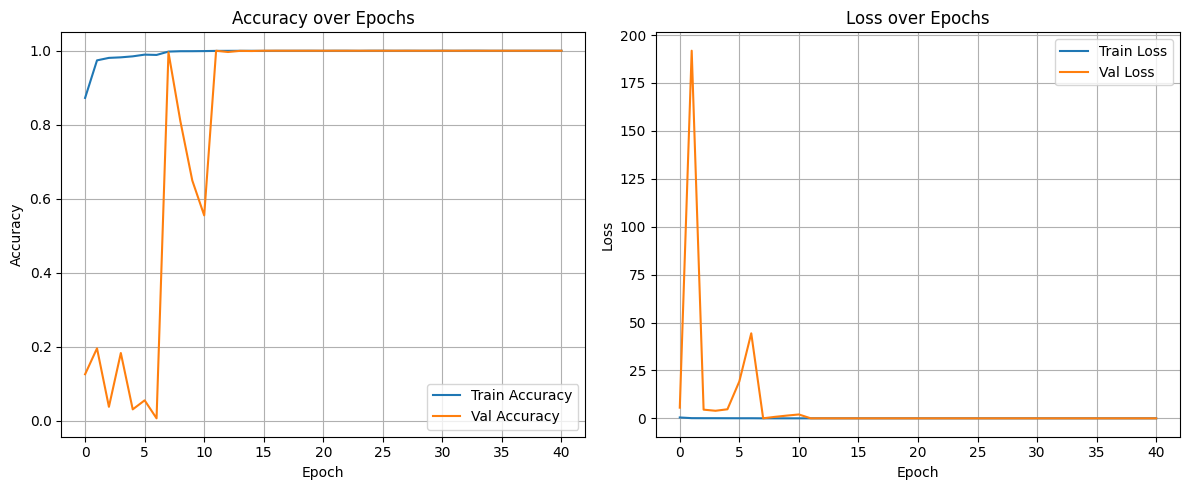

In [10]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# **Computing and Visualizing Test Set Evaluation Metrics**

This cell calculates weighted accuracy, precision, recall, and F1 score on the test set, 
then visualizes these metrics in a bar chart for quick performance comparison.


Test Accuracy : 0.9974
Test Precision: 0.9974
Test Recall   : 0.9974
Test F1 Score : 0.9974


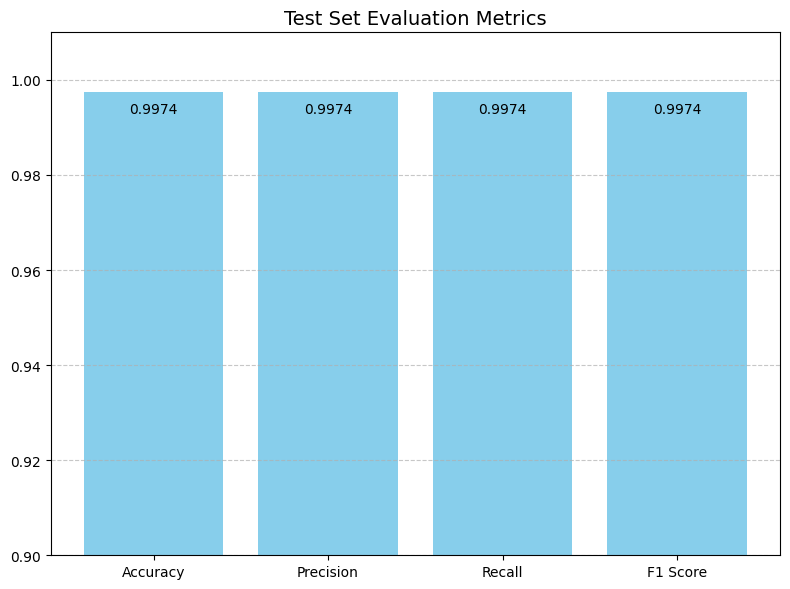

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

# ==== Compute metrics ====
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall    = recall_score(y_true, y_pred, average='weighted')
test_f1        = f1_score(y_true, y_pred, average='weighted')
test_accuracy  = accuracy_score(y_true, y_pred)

# Print values (optional)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall   : {test_recall:.4f}")
print(f"Test F1 Score : {test_f1:.4f}")

# ==== Plot ====
metrics = [test_accuracy, test_precision, test_recall, test_f1]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, metrics, color='skyblue')
plt.ylim(0.9, 1.01)  # Adjust based on your metric range
plt.title("Test Set Evaluation Metrics", fontsize=14)

# Annotate bars with values
for bar, metric in zip(bars, metrics):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height - 0.005, f"{metric:.4f}",
             ha='center', va='bottom', fontsize=10, color='black')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
